In [34]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install ipykernel

In [36]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [91]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, scale
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

import plotly.express as px

import pickle

In [38]:
# Carregar o arquivo de dados
dados = pd.read_csv(r'C:\Users\cacoc\OneDrive\Área de Trabalho\ESTUDOS\MEUS PROJETOS\PYTHON\E-comerce_cluester\data\E-comerce.csv', encoding= 'unicode_escape')

# EDA

In [39]:
# Descrição estatística dos dados
dados.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


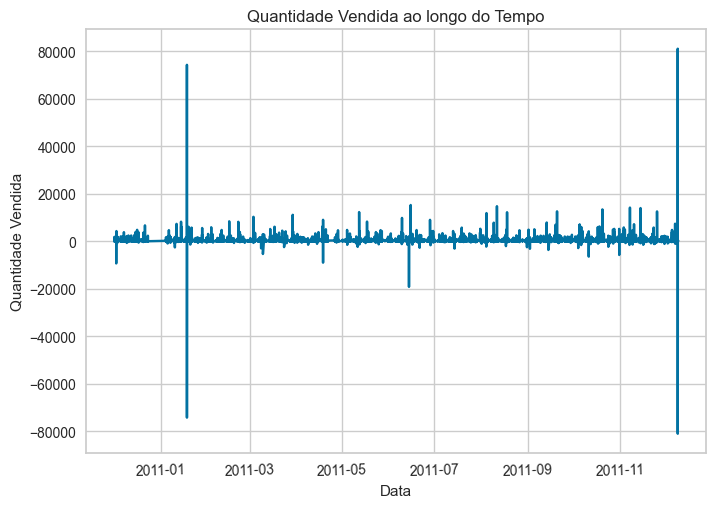

In [68]:
# Converter a coluna InvoiceDate para o tipo datetime
dados['InvoiceDate'] = pd.to_datetime(dados['InvoiceDate'])

# Agrupar a quantidade de produtos vendidos por data
sales_by_date = dados.groupby('InvoiceDate')['Quantity'].sum()

# Criar o gráfico de linhas
plt.plot(sales_by_date.index, sales_by_date.values)
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.title('Quantidade Vendida ao longo do Tempo')
plt.xticks(rotation=2)
plt.show()

# RFV

In [40]:
dados['InvoiceDate'] = pd.to_datetime(dados['InvoiceDate'])

# Calcular a diferença de dias em relação à data atual
dados['Recency'] = (pd.Timestamp.today() - dados['InvoiceDate']).dt.days

# RFV
df_rfv = (
    dados.groupby('CustomerID')
    .agg(
        R = ('InvoiceDate', lambda x: (pd.Timestamp.today() - x.max()).days),
        F = ('InvoiceNo', 'count'),
        V = ('UnitPrice', 'sum')
    )
)

df_rfv_clip = df_rfv.apply(lambda x: x.clip(upper=x.mean()+x.std()*4))

In [41]:
df_rfv_clip

,R,F,V
CustomerID,,,
12346.0,4519,2.0,2.08
12347.0,4196,182.0,481.21
12348.0,4269,31.0,178.71
12349.0,4212,73.0,605.10
12350.0,4504,17.0,65.30
...,...,...,...
18280.0,4471,10.0,47.65
18281.0,4374,7.0,39.36
18282.0,4201,13.0,62.68


In [59]:
df_rfv_clip_scale = df_rfv_clip.apply(scale)
df_rfv_clip_scale

,R,F,V
CustomerID,,,
12346.0,2.316568,-0.653488,-0.555933
12347.0,-0.889050,0.735982,0.397032
12348.0,-0.164560,-0.429629,-0.204625
12349.0,-0.730258,-0.105419,0.643442
12350.0,2.167700,-0.537699,-0.430192
...,...,...,...
18280.0,1.840191,-0.591734,-0.465297
18281.0,0.877514,-0.614892,-0.481785
18282.0,-0.839427,-0.568576,-0.435403


<Axes: >

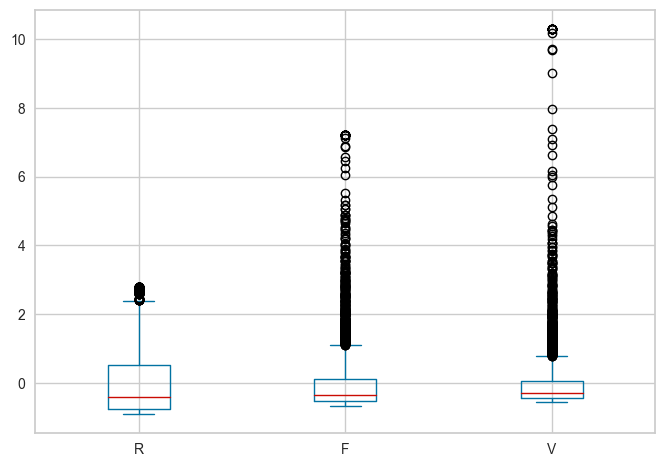

In [43]:
df_rfv_clip_scale.plot.box()

# Modeling

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\cacoc\AppData\Local\Packages\PythonSoftw

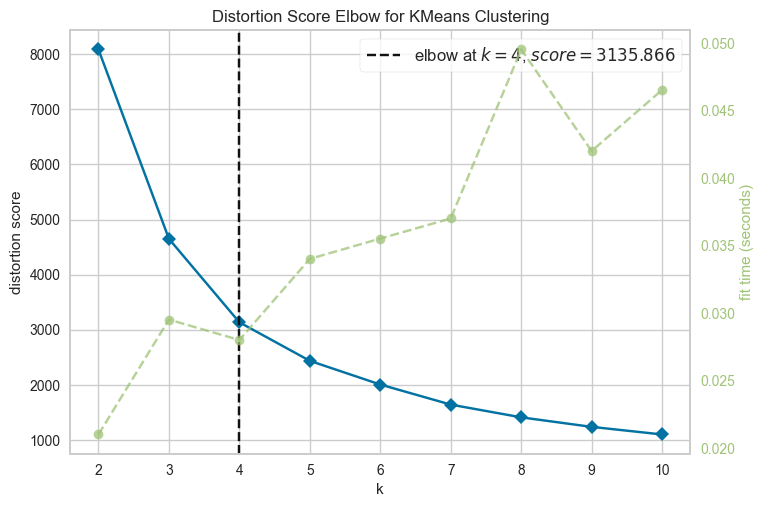

In [44]:
kelbow_visualizer(KMeans(), df_rfv_clip_scale, k=range(2,11));

In [45]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=2023)
  labels = model.fit_predict(df_rfv_clip_scale)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_
  
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_rfv_clip_scale, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Blues')

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\cacoc\AppData\Local\Packages\PythonSoftw

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8084.954817,0.643393,0.769795,2719.342248
3,4650.129324,0.551948,0.657588,3977.057449
4,3134.717519,0.561323,0.695116,4636.074684
5,2436.604464,0.525406,0.709587,4785.035474
6,2006.505394,0.472911,0.716309,4834.700427
7,1642.676939,0.457330,0.749904,5081.244115
8,1410.301756,0.458686,0.661323,5174.542756
9,1239.467573,0.443061,0.688983,5225.806390
10,1100.820728,0.392038,0.723055,5290.237569


In [46]:
kmeans_model = KMeans(n_clusters=4, random_state=2023)
labels = kmeans_model.fit_predict(df_rfv_clip_scale).astype(str)

px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

C:\Users\cacoc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



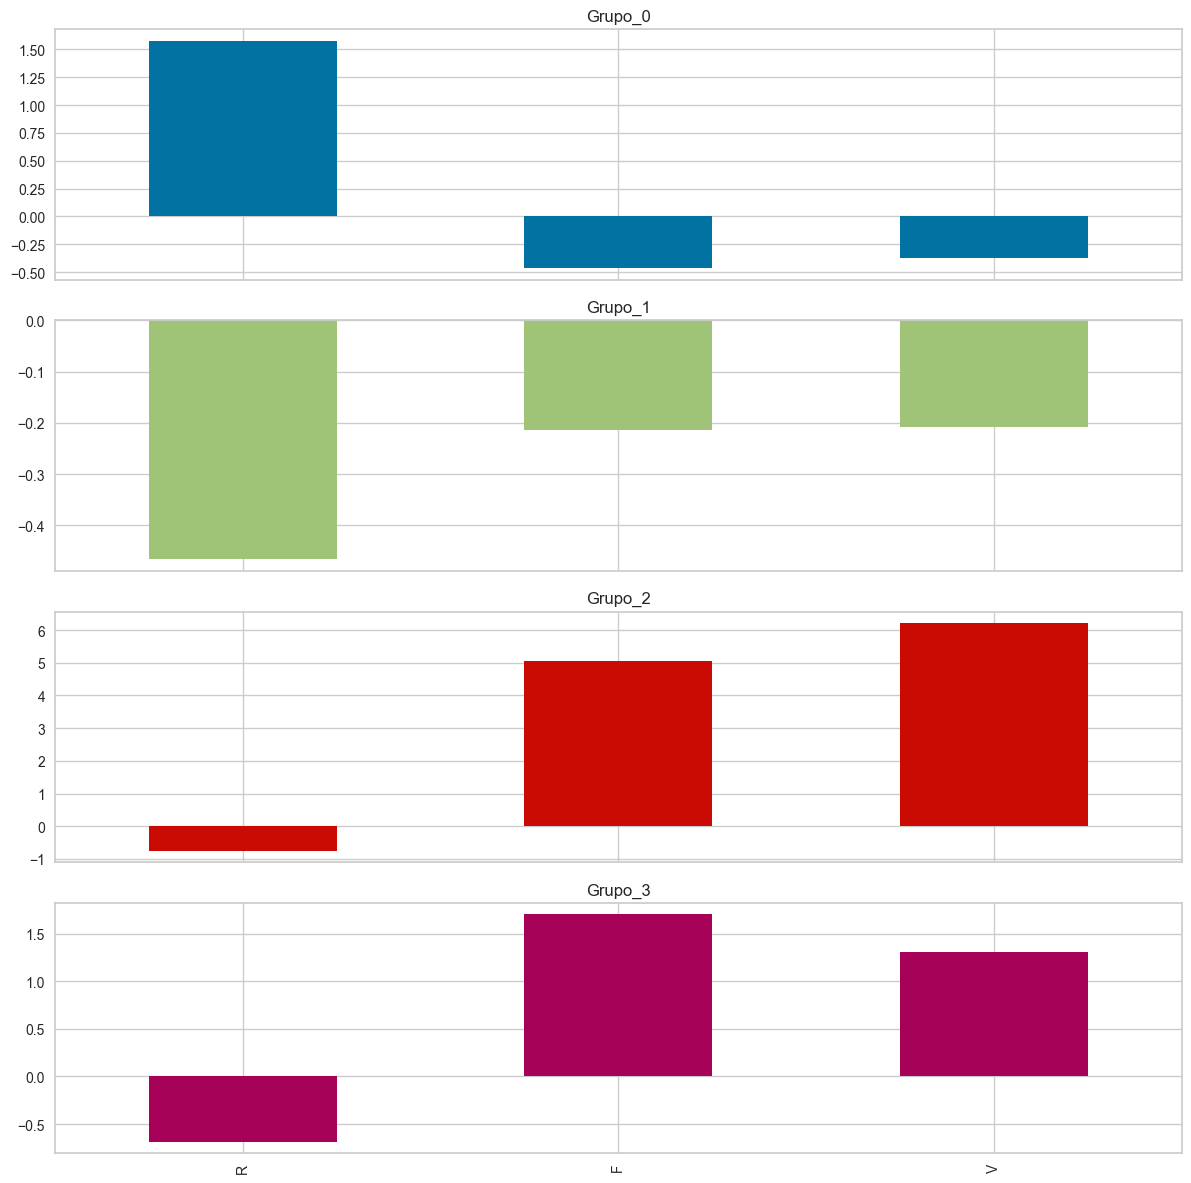

In [47]:
pd.DataFrame(kmeans_model.cluster_centers_, columns=df_rfv_clip_scale.columns).T.add_prefix('Grupo_').plot.bar(subplots=True, figsize=(12,12), legend=False)
plt.tight_layout();

In [61]:
df_rfv_clip.groupby(labels).agg(['mean','size'])

R                 F                  V      
          mean  size        mean  size         mean  size
0  4444.580645  1054   26.303605  1054    94.158473  1054
1  4238.716076  2793   58.916935  2793   177.209421  2793
2  4210.379310    58  739.719555    58  3406.139460    58
3  4216.353319   467  307.665953   467   940.837687   467

In [62]:
df_rfv_clip.groupby(labels).median() \
.style.background_gradient(cmap='Oranges')

,R,F,V
0,4440.000000,18.000000,61.945000
1,4227.000000,45.000000,136.700000
2,4199.000000,790.500000,2792.660000
3,4205.000000,278.000000,837.320000


# Deploy

In [92]:
with open('../models/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Resultados

Cluster 0:

Recency (R): 4440.000000 - Esse cluster possui clientes com alta recência, ou seja, eles não fizeram compras recentemente.

Frequency (F): 18.000000 - A frequência de compras dos clientes desse cluster é baixa.

MonetaryValue (V): 61.945000 - O valor monetário médio das compras dos clientes desse cluster é baixo.

Insight: Os clientes desse cluster têm um baixo envolvimento recente, compram com pouca frequência e têm um baixo valor médio de compras. Isso pode indicar um grupo de clientes inativos ou de menor importância para a empresa. Ações possíveis podem incluir estratégias de reengajamento, ofertas especiais ou segmentação para entender melhor suas necessidades.

------------------------

Cluster 1:

.Recency (R): 4227.000000 - Esse cluster possui clientes com uma recência moderada, ou seja, eles fizeram compras há algum tempo.

.Frequency (F): 45.000000 - A frequência de compras dos clientes desse cluster é moderada.

.MonetaryValue (V): 136.700000 - O valor monetário médio das compras dos clientes desse cluster é moderado.

Insight: Os clientes desse cluster estão mais engajados do que o Cluster 0, com uma recência moderada e uma frequência e valor médio de compras também moderados. Eles representam um segmento intermediário em termos de envolvimento e valor. Ações possíveis podem incluir ações de fidelização, promoções específicas para incentivar compras mais frequentes ou personalização das ofertas com base em seu histórico de compras.

-------------------

Cluster 2:

Recency (R): 4199.000000 - Esse cluster possui clientes com uma recência relativamente baixa, ou seja, eles fizeram compras recentemente.

Frequency (F): 790.500000 - A frequência de compras dos clientes desse cluster é alta.

MonetaryValue (V): 2792.660000 - O valor monetário médio das compras dos clientes desse cluster é alto.

Insight: Os clientes desse cluster são bastante ativos, com uma recência baixa, uma frequência de compras alta e um valor médio de compras alto. Eles representam um grupo de alto valor para a empresa e podem ser considerados clientes fiéis e valiosos. Ações possíveis podem incluir programas de recompensas, tratamento VIP, comunicações personalizadas e oferta de produtos e serviços exclusivos.

-----

Cluster 3:

Recency (R): 4205.000000 - Esse cluster possui clientes com uma recência moderada, ou seja, eles fizeram compras há algum tempo.

Frequency (F): 278.000000 - A frequência de compras dos clientes desse cluster é moderada.

MonetaryValue (V): 837.320000 - O valor monetário médio das compras dos clientes desse cluster é moderado.


Insight: Os clientes desse cluster têm uma recência moderada, uma frequência de compras moderada e um valor médio de compras moderado. Eles representam um segmento intermediário em termos de envolvimento e valor. Ações possíveis podem incluir estratégias de retenção,

------